# Набор данных

**Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии**

Набор данных представляет собой статистику параметров автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный параметр.

Среди указанных параметров приведены целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди параметров есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий параметр).

**Примечание**: в этом блокноте отклонимся от стандартной практики импорта всех функций в самом начале

Импортировать будем много и сделаем это постепенно

# Загружаем данные в Pandas

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
from google.colab import files  # чтобы загружать файлы в облако через проводник

import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации

import numpy as np # библиотека Numpy для операций линейной алгебры и прочего

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn

from sklearn.model_selection import GridSearchCV # для поиска по сетке гиперпараметров
# альтернативно можно воспользоваться RandomizedSearchCV

from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn

from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn import preprocessing as prep  # общий модуль предварительной обработки scikit-learn
from sklearn import set_config # для доп настроек

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.metrics import make_scorer #функция для создания объекта из метрики для использования в кросс-валидации


from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import PredictionErrorDisplay

from sklearn.preprocessing import QuantileTransformer

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Загружаем наши данные из файла по прямой ссылке на git-hub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32601,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32602,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32603,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32604,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


# Работа с данными

### Посчитаем число численных и категориальных колонок

In [ ]:
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))



categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
 len =  5
numerical columns:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)'] 
 len =  4


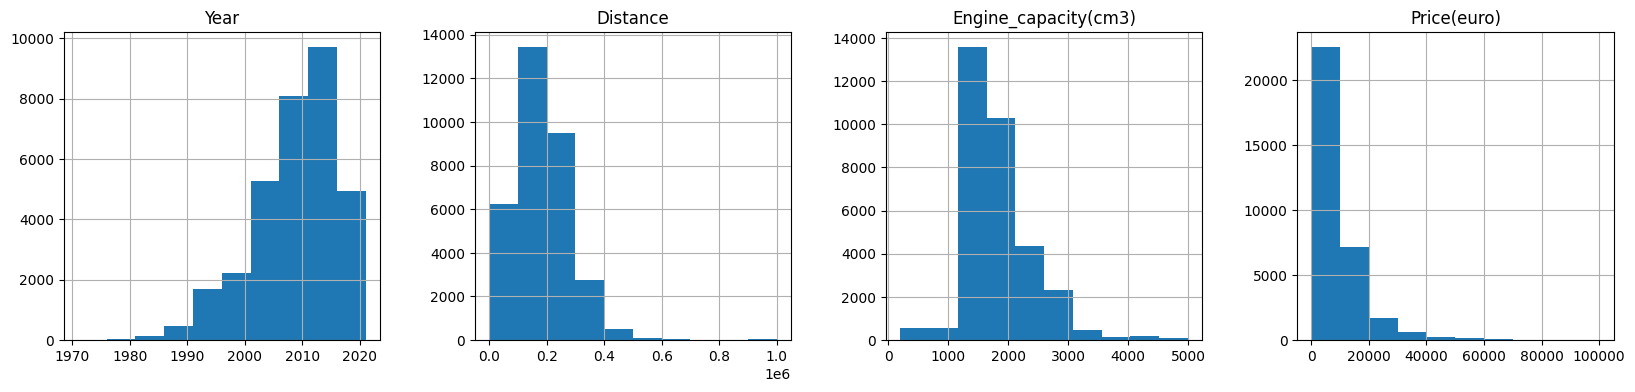

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,  4))# создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет 1 строка и 5 столбца

DF.hist(column = num_columns, ax = axs );

Делаем вывод о том, что `Distance` и `Engine_Capacity` условно нормальные (хотя в `Distance`  можно и подрезать редкие значения), их можно просто нормировать / стандартизировать

`Year` и `Price` лучше нелинейно преобразовывать

In [ ]:
from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

# Предварительная Обработка

### Допустим смотрим задачу **регрессию**

In [ ]:
data = DF.drop(columns = ['Price(euro)']) # в признаках нам не нужен 'Price(euro)'
target = DF['Price(euro)'] # поскольку это целевая метка

Уберем из списка числовых признаков `'Price(euro)'`

In [ ]:
num_columns.pop(3)

'Price(euro)'

In [ ]:
num_columns

['Year', 'Distance', 'Engine_capacity(cm3)']

Разобъем Тренировочную выборку на тренировочную и валидационную (не забываем фиксировать сид при разбиении)

In [ ]:
random_state = 42

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data,target,
                                                  test_size = 0.2, random_state = random_state)

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных

## Сначала создадим заменятель редких значений

Спасибо ChatGPT

Промпт

`Can you implement class QuantileReplacer using sklearn libriaries to replace rare numberical values . This class takes as input relative threshold value and replace all rare values with values based on quantile. If the value is rare and it is high than it should be replaced with high quantile value, if it is rare and low than it should be replaced with low quantile value
The input is pandas dataframe. During fit you should first find all features that are below or higher than quintile threshold.
During transform you replace rare numerical features with values based on Quantiles`

Ответ

`As an AI language model, I cannot implement code directly. However, I can provide you with a sample implementation of the QuantileReplacer class using scikit-learn libraries:`

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

This implementation defines the `QuantileReplacer` class that inherits from scikit-learn's `BaseEstimator` and `TransformerMixin` classes. The class takes a `threshold` parameter that determines the relative threshold value for identifying rare numerical values. The fit method calculates the low and high quantiles for each numerical feature in the input pandas dataframe and stores them in a dictionary. The transform method replaces rare numerical values with values based on the quantiles stored in the dictionary. If the rare value is higher than the mean of the low and high quantiles, it is replaced with the high quantile value. Otherwise, it is replaced with the low quantile value.


```
# Instantiate the QuantileReplacer class
qr = QuantileReplacer(threshold=0.05)

# Fit the class to the input data
qr.fit(X_train)

# Transform the input data by replacing rare numerical features with values based on quantiles
X_train_transformed = qr.transform(X_train)
```

```
Примечание

Я даже этого не упоминал, но коллективное бессознательное понимает что fit надо делать только на тренировочных данных!!!

```





Тестируем

In [ ]:
qr = QuantileReplacer(threshold=0.01, )

qr.fit(X_train)

X_train_transformed = qr.transform(X_train)

In [ ]:
X_train.describe()

,Year,Distance,Engine_capacity(cm3)
count,26084.000000,26084.000000,26084.000000
mean,2008.264070,181191.815711,1864.669529
std,7.258888,99136.608072,606.110392
min,1971.000000,0.000000,200.000000
25%,2004.000000,121092.250000,1500.000000
50%,2010.000000,180000.000000,1800.000000
75%,2014.000000,236000.000000,2000.000000
max,2021.000000,1000000.000000,5000.000000


In [ ]:
X_train_transformed.describe()

,Year,Distance,Engine_capacity(cm3)
count,26084.000000,26084.000000,26084.000000
mean,2008.155843,184347.304823,1860.079512
std,7.200242,95153.239237,587.236458
min,1988.000000,1989.000000,200.000000
25%,2004.000000,123456.000000,1500.000000
50%,2009.000000,180000.000000,1800.000000
75%,2014.000000,240000.000000,2000.000000
max,2020.000000,450000.000000,4000.000000


## Предобработка числовых данных (замена редких + нормализация)

In [ ]:
numerical_pipe = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),

    ('scaler', MinMaxScaler())

])

index_scale = [1,2]
num_scale = [num_columns[x] for x in index_scale]
num_scale

['Distance', 'Engine_capacity(cm3)']

In [ ]:
numerical_pipe

Pipeline(steps=[('QuantReplace', QuantileReplacer(threshold=0.01)),
                ('scaler', MinMaxScaler())])

## Предобработка числовых данных (замена редких + степенное преобразование)

In [ ]:
numerical_pipe_power = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),

    ('scaler', PowerTransformer())

])

index_power = [0]
num_power = [num_columns[x] for x in index_power]
num_power

['Year']

## Напишем заменятель редких категориальных данных

Написано с помощью ChatGPT

промпт

`Can you implement class RareGrouper using sklearn libriaries. This class takes as input relative threshold value and replace all rare values with Other value.
The input is pandas dataframe. During fit you should first find relative frequency of categorical features in the input for all features
During transform you replace rare categorical features with Other value`














In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

The `RareGrouper` class inherits from `BaseEstimator` and `TransformerMixin` classes from sklearn. The `fit` method calculates the relative frequency of categorical features in the input dataframe and stores them in a dictionary. The `transform` method replaces rare categorical features with the `other_value` specified during initialization.

To use this class, we can create an instance and call the `fit_transform` method on the input dataframe:

```
python
rg = RareGrouper(threshold=0.05, other_value='Other')
X_transformed = rg.fit_transform(X)`
```
Here, `X` is the input pandas dataframe and `X_transformed` is the transformed dataframe with rare categorical features replaced with the `other_value`.

Аналогичным образом поступаем для категориальных данных

In [ ]:
rg = RareGrouper(threshold=0.01, other_value='Other')
X_transformed = rg.fit_transform(X_train[cat_columns])
X_transformed

,Make,Model,Style,Fuel_type,Transmission
5449,Skoda,Other,Crossover,Petrol,Automatic
27699,Mercedes,E Class,Sedan,Petrol,Manual
22043,Volkswagen,Golf,Hatchback,Petrol,Automatic
28975,Audi,Other,Crossover,Petrol,Automatic
4252,Volkswagen,Passat,Universal,Diesel,Automatic
...,...,...,...,...,...
29802,BMW,3 Series,Coupe,Petrol,Manual
5390,Dacia,Other,Universal,Petrol,Manual
860,Renault,Grand Scenic,Universal,Diesel,Automatic
15795,BMW,3 Series,Sedan,Diesel,Manual


## Предобработка категориальных данных (замена редких + One-Hot кодирование)

In [ ]:
categorical_pipe = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.01, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

In [ ]:
categorical_pipe

Pipeline(steps=[('replace_rare', RareGrouper(threshold=0.01)),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

## Объединяем в единый Трансформер Колонок Данных

Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num_scale', numerical_pipe, num_scale),
    ('num_power', numerical_pipe_power, num_power),
    ('cat', categorical_pipe, cat_columns)
])

In [ ]:
preprocessors

ColumnTransformer(transformers=[('num_scale',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)']),
                                ('num_power',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['Year']),
                                ('cat',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.01)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

"Обучаем" стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся "по именам". Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [ ]:
preprocessors.fit(X_train);

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
cat_ohe_names = preprocessors.transformers_[2][1]['encoder'].get_feature_names_out(cat_columns)
columns = np.append(num_scale,num_power)
columns = np.append(columns,cat_ohe_names) # объединяем названия колонок

In [ ]:
X_train_transformed = preprocessors.transform(X_train)
pd.DataFrame(X_train_transformed, columns=columns)

,Distance,Engine_capacity(cm3),Year,Make_Audi,Make_BMW,Make_Dacia,Make_Ford,Make_Honda,Make_Hyundai,Make_KIA,...,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Other,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual
0,0.375015,0.263158,0.346257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.270107,0.473684,-1.290188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.196448,0.421053,1.171517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.375015,0.473684,0.503899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.567823,0.604211,-0.662265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26079,0.584832,0.471316,-1.743318,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
26080,0.330374,0.184211,0.830131,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
26081,0.345556,0.342105,1.348105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
26082,0.665187,0.000000,-0.793649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Объединяем Pipeline Предобработки и Модель

Синтаксис - тот же
Список из
* имен
* объектов

In [ ]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', SGDRegressor())
])

Чтобы "обратиться" к части Pipeline - достаточно помнить "имя"

In [ ]:
pipe['preprocessors']

ColumnTransformer(transformers=[('num_scale',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)']),
                                ('num_power',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['Year']),
                                ('cat',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.01)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

In [ ]:
pipe['model']

SGDRegressor()

In [ ]:
pipe

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.01)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model', SGDRegressor())])

Так же обучаем через `.fit()`

In [ ]:
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.01)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model', SGDRegressor())])

In [ ]:
def calculate_r2_score(model_pipe, X, y):
    """Расчет коэффициента f1.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    """
    y_model = model_pipe.predict(X)
    return r2_score(y, y_model)

Оценим модель на Тренировочных и Валидационных данных

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_r2_score(pipe, X_train, y_train):.4f}")

print(f"r2 на валидационной выборке: {calculate_r2_score(pipe, X_val, y_val):.4f}")

r2 на тренировочной выборке: 0.5316
r2 на валидационной выборке: 0.5332


### Визуализация ошибок от scikit-learn

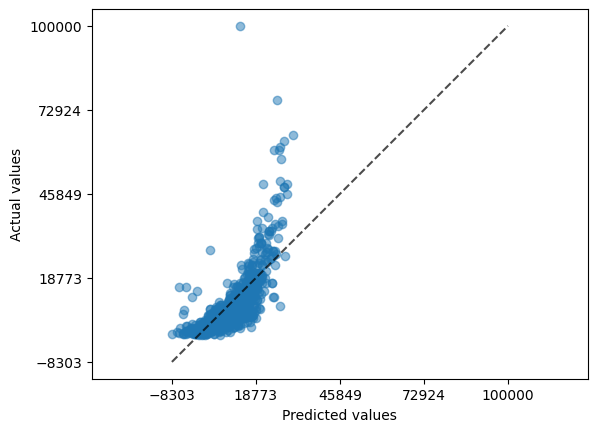

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

### От ChatGPT



Промпт

`write a python function to visualize errors of regression models`

Комментарий от **ChatGPT**

This function takes in two arrays: `y_true` contains the true target values and `y_pred` contains the predicted target values. It calculates the errors by subtracting `y_pred` from `y_true`, and then plots a histogram of the errors. The function also adds vertical lines to indicate the mean error and one standard deviation from the mean. This can help to identify whether the errors are normally distributed and whether the model is under- or over-predicting certain values.

In [ ]:
def plot_regression_errors(y_true, y_pred):
    """
    Plots the errors of a regression model.

    Args:
    - y_true: the true target values
    - y_pred: the predicted target values
    """
    errors = y_true - y_pred
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    plt.hist(errors, bins=20, log= True)
    plt.axvline(x=mean_error, color='r', linestyle='--', label='Mean Error')
    plt.axvline(x=mean_error + std_error, color='g', linestyle='--', label='1 Std Dev')
    plt.axvline(x=mean_error - std_error, color='g', linestyle='--')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Regression Model Errors')
    plt.legend()
    plt.show()

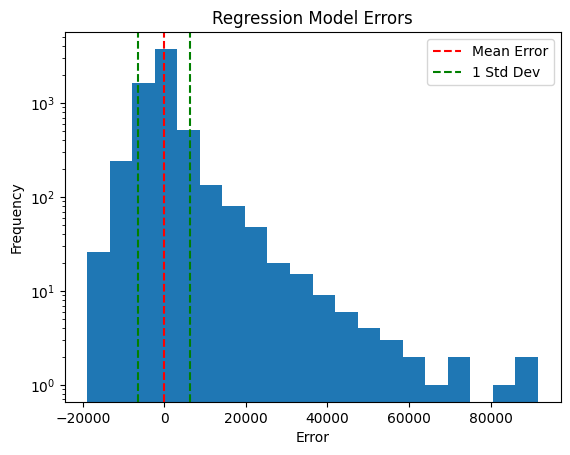

In [ ]:
plot_regression_errors(y_val,
                       pipe.predict(X_val))

## Подождите!

Мы забыли поправить целевую метку - она же была не нормальная (в смысле нормального распределения)

И решение - `TransformedTargetRegressor`

In [ ]:
pipe_transform = Pipeline([
    ('preprocessors', preprocessors),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(),
    transformer=QuantileTransformer(n_quantiles=100, output_distribution="normal"))
    )
])

In [ ]:
pipe_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.01)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(),
                                            transformer=QuantileTransformer(n_quantiles=100,
                                                                            output_distribution='normal')))])

In [ ]:
pipe_transform.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.01)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(),
                                            transformer=QuantileTransformer(n_quantiles=100,
                                                                            output_distribution='normal')))])

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_r2_score(pipe_transform, X_train, y_train):.4f}")

print(f"r2 на валидационной выборке: {calculate_r2_score(pipe_transform, X_val, y_val):.4f}")

r2 на тренировочной выборке: 0.6294
r2 на валидационной выборке: 0.6332


Хм. + в метрику за то, что просто трансформировали целевую переменную. Нравится

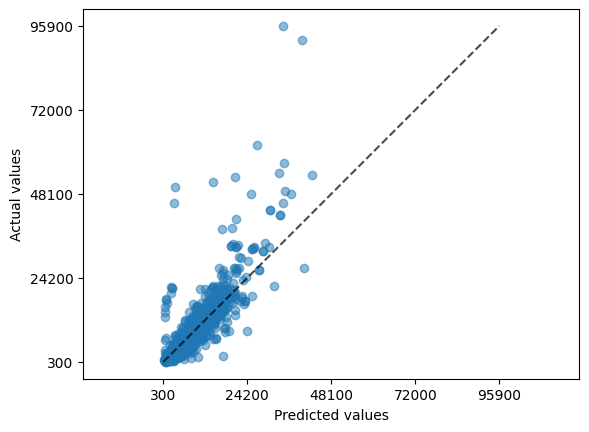

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

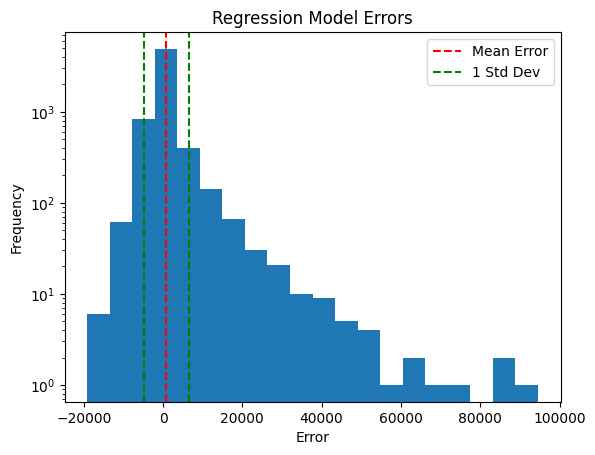

In [ ]:
plot_regression_errors(y_val,
                       pipe_transform.predict(X_val))

# Про Подбор гиперпараметров

In [ ]:
pipe_transform

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.01)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(),
                                            transformer=QuantileTransformer(n_quantiles=100,
                                                                            output_distribution='normal')))])

Можно протестировать разные пороги замены редких значений и разбиение на квантили в преобразовании целевой переменной

Задаем Словарь гиперпараметров, которые мы хотим проверить

In [ ]:
param_grid = {
    # ВАЖНО используем "имена" которые есть у компонент Pipeline и разделяем их __ (две земли)
    "preprocessors__num_scale__QuantReplace__threshold": [0.0,0.01, 0.1],
    "preprocessors__num_power__QuantReplace__threshold": [0.0,0.01, 0.1],
    "preprocessors__cat__replace_rare__threshold": [0.0,0.01, 0.1],
    "model__transformer__n_quantiles": np.arange(100,1200,500),
   # "model__regressor__penalty": ['l1','l2'],
}

In [ ]:
scorer = make_scorer(r2_score)

Складываем всё аккуратно в GridSearch (можно и в Random Search)

In [ ]:
Pipe_GS = GridSearchCV(estimator = pipe_transform, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       scoring = scorer, # указываем метрику которую оптимизируем
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num_scale',
                                                                         Pipeline(steps=[('QuantReplace',
                                                                                          QuantileReplacer(threshold=0.01)),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Distance',
                                                                          'Engine_capacity(cm3)']),
                                                                        ('num_power',
                                                                         Pipeline(steps=[('QuantReplace...
                                                                   transformer=QuantileTransformer(n_quantiles=100,
                                                                                                   output_distribution='normal')))]),
             param_grid={'model__transformer__n_quantiles': array([ 100,  600, 1100]),
                         'preprocessors__cat__replace_rare__threshold': [0.0,
                                                                         0.01,
                                                                         0.1],
                         'preprocessors__num_power__QuantReplace__threshold': [0.0,
                                                                               0.01,
                                                                               0.1],
                         'preprocessors__num_scale__QuantReplace__threshold': [0.0,
                                                                               0.01,
                                                                               0.1]},
             scoring=make_scorer(r2_score), verbose=2)

Поехали смотреть (посчитает кратно дольше, поскольку в этот раз перебираем и гиперпараметр модели, и гиперпараметр уменьшения размерности)

Стандартное обучение через метод `.fit()`

В этом случае он будет тестировать для выбранного `estimator` все перечисленные комбинации гиперпараметров / аргументов из `param_grid`

In [ ]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END model__transformer__n_quantiles=100, preprocessors__cat__replace_rare__threshold=0.0, preprocessors__num_power__QuantReplace__threshold=0.0, preprocessors__num_scale__QuantReplace__threshold=0.0; total time=   1.2s
[CV] END model__transformer__n_quantiles=100, preprocessors__cat__replace_rare__threshold=0.0, preprocessors__num_power__QuantReplace__threshold=0.0, preprocessors__num_scale__QuantReplace__threshold=0.0; total time=   1.4s
[CV] END model__transformer__n_quantiles=100, preprocessors__cat__replace_rare__threshold=0.0, preprocessors__num_power__QuantReplace__threshold=0.0, preprocessors__num_scale__QuantReplace__threshold=0.0; total time=   1.8s
[CV] END model__transformer__n_quantiles=100, preprocessors__cat__replace_rare__threshold=0.0, preprocessors__num_power__QuantReplace__threshold=0.0, preprocessors__num_scale__QuantReplace__threshold=0.0; total time=   1.5s
[CV] END model__transformer__n_quantiles=1

Лучший Кандидат

In [ ]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.0)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.0)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(),
                                            transformer=QuantileTransformer(n_quantiles=1100,
                                                                            output_distribution='normal')))])

In [ ]:
Pipe_best.fit(X_train, y_train);

### Проанализируем ошибки модели

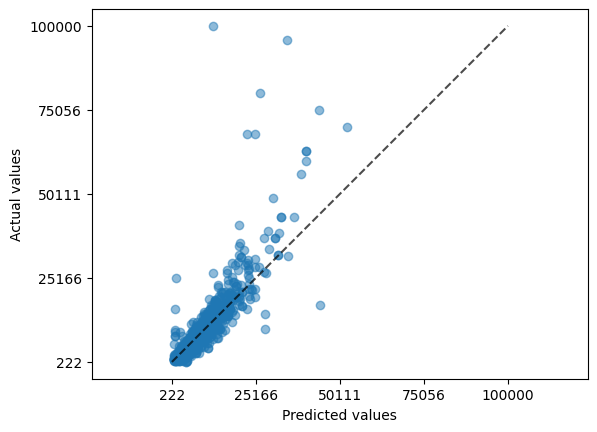

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    Pipe_best.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

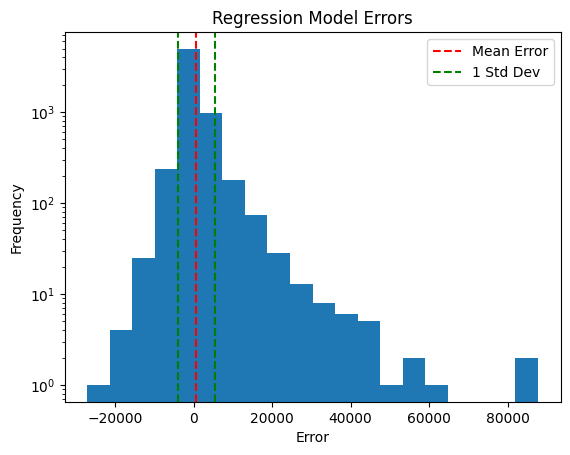

In [ ]:
plot_regression_errors(y_val, Pipe_best.predict(X_val))

In [ ]:
Pipe_best['preprocessors']

ColumnTransformer(transformers=[('num_scale',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.0)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)']),
                                ('num_power',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.0)),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['Year']),
                                ('cat',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.0)),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

### Проанализируем полученную модельку (как обычно с помощью ChatGPT)



Промпт

`Create a python function that can be used to analyze results of linear regression models. It should take as an input weights of the model, names of the features as well as threshold value. If weight is less then threshold than the feature is ignored.
The function should visualize barplot, by values of the coefficient. If the coefficient is positive than bar should be blue, otherwise - blue.
Names of the features should be used on the axis`

Ответ
`Here's an implementation of the requested function:`

Примечание: я только добавил строчку (чтобы названия признаков были вертикально)

    plt.xticks(rotation = 90);  

Кто-то забыл что "языковая модель не может кодить"?))

In [ ]:
def analyze_regression(weights, feature_names, threshold):
    # Filter out features with weights below threshold
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask) if m]

    # Create bar plot
    colors = np.where(weights_filtered > 0, 'b', 'r')
    plt.bar(feature_names_filtered, weights_filtered, color=colors)
    plt.xticks(rotation = 90);
    plt.axhline(0, color='k')
    plt.xlabel('Feature')
    plt.ylabel('Coefficient')
    plt.title('Linear Regression Coefficients')
    plt.show()


The function takes three arguments:

- `weights`: a 1D array of coefficients for each feature in the model.
- `feature_names`: a list of strings containing the names of each feature in the same order as the `weights` array.
- `threshold`: a float value representing the minimum absolute value of a coefficient for it to be included in the plot.

The function first filters out any coefficients with an absolute value less than `threshold`. It then creates a bar plot using `plt.bar()`, coloring each bar blue if the coefficient is positive and red if it is negative. The x-axis labels are set to the feature names and the y-axis label is set to "Coefficient". Finally, the plot is displayed using `plt.show()`.

1.  "Вытащим" из модели веса линейной регрессии

In [ ]:
b0 = Pipe_best['model'].regressor_.intercept_
B = Pipe_best['model'].regressor_.coef_
Bs = np.hstack([b0,B])

2. Подготовим список имен признаков (не забываем про независимую константу)

In [ ]:
cat_ohe_names = Pipe_best['preprocessors'].transformers_[2][1]['encoder'].get_feature_names_out(cat_columns)
columns = np.append('b0',num_scale)
columns = np.append(columns,num_power)
columns = np.append(columns,cat_ohe_names) # объединяем названия колонок

3. Рисуем с помощью функцию, которую нам сделала ChatGPT

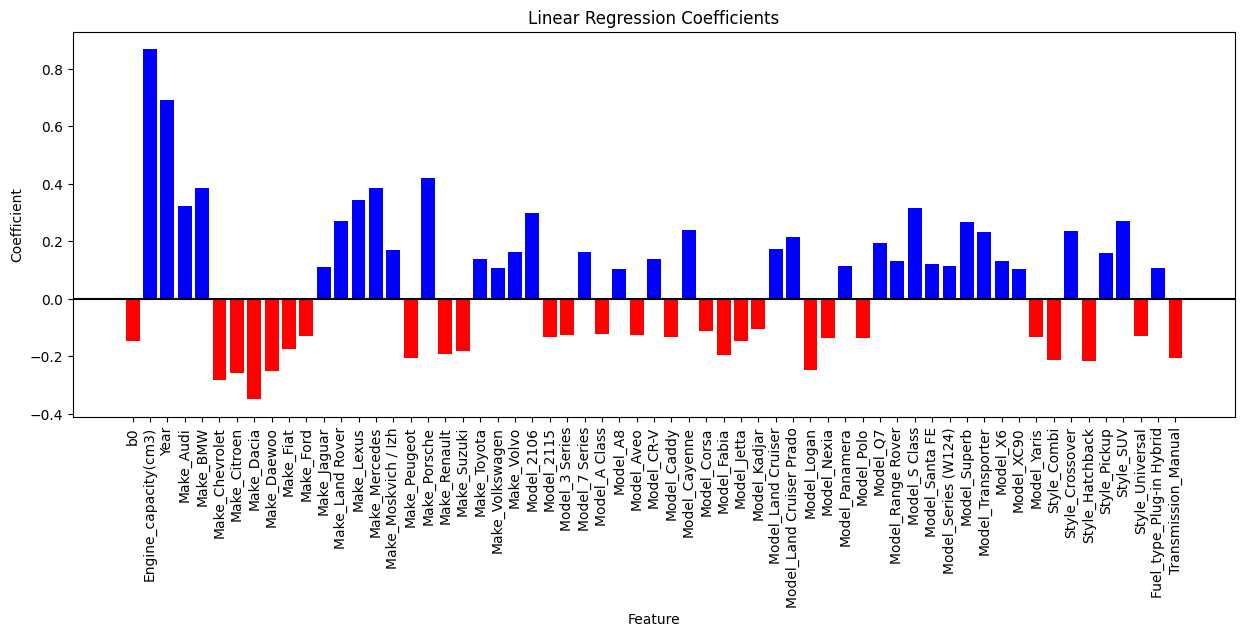

In [ ]:
fig = plt.figure(figsize = (15,5))
analyze_regression(Bs,columns, 0.01)

### Проанализируем результат

На уровне гиперпараметров

In [ ]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__transformer__n_quantiles,param_preprocessors__cat__replace_rare__threshold,param_preprocessors__num_power__QuantReplace__threshold,param_preprocessors__num_scale__QuantReplace__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.366431,0.208349,0.051826,0.012252,100,0.0,0.0,0.0,"{'model__transformer__n_quantiles': 100, 'prep...",0.753893,0.733905,0.744726,0.740913,0.788320,0.752351,0.019107,6
1,1.221239,0.014929,0.046432,0.007318,100,0.0,0.0,0.01,"{'model__transformer__n_quantiles': 100, 'prep...",0.763404,0.727978,0.741684,0.749906,0.788273,0.754249,0.020535,5
2,1.392703,0.193960,0.050248,0.011061,100,0.0,0.0,0.1,"{'model__transformer__n_quantiles': 100, 'prep...",0.725529,0.709292,0.724937,0.715299,0.746459,0.724303,0.012643,9
3,1.473659,0.176551,0.047249,0.008072,100,0.0,0.01,0.0,"{'model__transformer__n_quantiles': 100, 'prep...",0.702069,0.688683,0.726195,0.695733,0.659634,0.694463,0.021508,19
4,1.278070,0.195977,0.049315,0.008578,100,0.0,0.01,0.01,"{'model__transformer__n_quantiles': 100, 'prep...",0.694702,0.676015,0.709619,0.697505,0.664765,0.688521,0.016030,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.235193,0.004198,0.023439,0.003560,1100,0.1,0.01,0.01,"{'model__transformer__n_quantiles': 1100, 'pre...",0.606082,0.580877,0.609204,0.599430,0.566259,0.592370,0.016341,45
77,0.233319,0.005198,0.021964,0.000895,1100,0.1,0.01,0.1,"{'model__transformer__n_quantiles': 1100, 'pre...",0.529193,0.538197,0.567927,0.529671,0.511996,0.535397,0.018357,54
78,0.216850,0.007136,0.022457,0.003320,1100,0.1,0.1,0.0,"{'model__transformer__n_quantiles': 1100, 'pre...",0.334611,0.304190,0.336546,0.312287,0.328974,0.323322,0.012822,75
79,0.212525,0.007730,0.023271,0.001398,1100,0.1,0.1,0.01,"{'model__transformer__n_quantiles': 1100, 'pre...",0.360099,0.326740,0.355637,0.323992,0.329061,0.339106,0.015468,71


In [ ]:
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__transformer__n_quantiles',
       'param_preprocessors__cat__replace_rare__threshold',
       'param_preprocessors__num_power__QuantReplace__threshold',
       'param_preprocessors__num_scale__QuantReplace__threshold', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

Оставим минимум информации

In [ ]:
DF_ = DF_Pipe[[ 'mean_test_score', #среднее значение метрики на кросс-валидации
             'std_test_score', # разбросс метрики на кросс-валидации
             'rank_test_score',# место
 # берем только гиперпараметры,
       'param_model__transformer__n_quantiles',
       'param_preprocessors__cat__replace_rare__threshold',
       'param_preprocessors__num_power__QuantReplace__threshold',
       'param_preprocessors__num_scale__QuantReplace__threshold',
             ]]
cm = sns.light_palette("orange", as_cmap=True) # делаем подсцветку по значению. В этот раз "50 оттенков Оранжевого"
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) # сортируем по убыванию места и раскрашиваем
hl

,mean_test_score,std_test_score,rank_test_score,param_model__transformer__n_quantiles,param_preprocessors__cat__replace_rare__threshold,param_preprocessors__num_power__QuantReplace__threshold,param_preprocessors__num_scale__QuantReplace__threshold
54,0.756670,0.018841,1,1100,0.000000,0.000000,0.000000
28,0.756610,0.016879,2,600,0.000000,0.000000,0.010000
27,0.756505,0.014619,3,600,0.000000,0.000000,0.000000
55,0.755304,0.016526,4,1100,0.000000,0.000000,0.010000
1,0.754249,0.020535,5,100,0.000000,0.000000,0.010000
0,0.752351,0.019107,6,100,0.000000,0.000000,0.000000
56,0.733461,0.015248,7,1100,0.000000,0.000000,0.100000
29,0.728962,0.015845,8,600,0.000000,0.000000,0.100000
2,0.724303,0.012643,9,100,0.000000,0.000000,0.100000
64,0.709086,0.021592,10,1100,0.010000,0.000000,0.010000


Мораль (для ЭТОГО набора данных и этой модели)

1. Замена **редких** значений в целом не очень оказывается полезной (хотя замена 1% редких числовых в целом не вредит)

2. Замена **большого** числа редких значений вообще вредная (порядка 10%)

3. Квантильное преобразование целевой переменной в целом работает. Чем больше - тем вроде лучше

# А теперь следите за руками (Target Encoding)

Промпт

`Can you implement transformer class TargetEncoder using sklearn libriaries to create Target Encoding of categorical features.
The task is regression, so you should encode by mean value of the target for each different unique categorical value
The input is pandas dataframe.`


In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.target_mean = {}

    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.target_mean[col] = {}
            X_copy = X.copy()
            X_copy[y.name]=y
            self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            X[col] = X[col].map(self.target_mean[col])
            X[col] = X[col].fillna(np.mean(X[col]))
        return X

The `TargetEncoder` class takes an optional parameter `cols` which is a list of columns to encode. If `cols` is not provided, it will encode all categorical columns in the dataframe.

The `fit` method calculates the mean target value for each unique value in the specified columns. It then stores the mean target values in a dictionary.

The `transform` method uses the mean target values stored in the dictionary to replace the categorical values with their corresponding mean target values. If a categorical value is not found in the dictionary, it is replaced with the mean of the column.

### Пересоберем наш `Pipeline`

*  Заменим `One-Hot encoding` на `TargetEncoding`
*  Подсктавим как-бы оптимальные значения для замены редких значений
* Отнормируем результат `TargetEncoding` чтобы не смущать



In [ ]:
categorical_pipe_te = Pipeline(
    [
    ('te', TargetEncoder()),
     ('scaler', MinMaxScaler())
])

numerical_pipe = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),

    ('scaler', MinMaxScaler())

])

numerical_pipe_power = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.00, )),

    ('scaler', PowerTransformer())

])

### Получили трансформатор

In [ ]:
preprocessors_te = ColumnTransformer(transformers=[
    ('num_scale', numerical_pipe, num_scale),
    ('num_power', numerical_pipe_power, num_power),
    ('cat', categorical_pipe_te, cat_columns)
])


### Проверяем

In [ ]:
preprocessors_te.fit(X_train, y_train)

ColumnTransformer(transformers=[('num_scale',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.01)),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)']),
                                ('num_power',
                                 Pipeline(steps=[('QuantReplace',
                                                  QuantileReplacer(threshold=0.0)),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['Year']),
                                ('cat',
                                 Pipeline(steps=[('te', TargetEncoder()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

Получили какие-то числа (наверное что-то хорошее)

In [ ]:
pd.DataFrame(preprocessors_te.transform(X_train))

,0,1,2,3,4,5,6,7
0,0.375015,0.263158,0.327313,0.159406,0.086394,0.890590,0.236963,1.0
1,0.270107,0.473684,-1.299673,0.250148,0.123974,0.354085,0.236963,0.0
2,0.196448,0.421053,1.147800,0.117809,0.061638,0.083748,0.236963,1.0
3,0.375015,0.473684,0.484043,0.238196,0.203959,0.890590,0.236963,1.0
4,0.567823,0.604211,-0.675379,0.117809,0.068540,0.124479,0.384635,1.0
...,...,...,...,...,...,...,...,...
26079,0.584832,0.471316,-1.750186,0.268170,0.073895,0.334773,0.236963,0.0
26080,0.330374,0.184211,0.808389,0.086290,0.049121,0.124479,0.236963,0.0
26081,0.345556,0.342105,1.323367,0.111731,0.073907,0.124479,0.384635,1.0
26082,0.665187,0.000000,-0.806004,0.268170,0.073895,0.354085,0.384635,0.0


### Обучаем модель

In [ ]:
pipe_te = Pipeline([
    ('preprocessors', preprocessors_te),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(),
    transformer=QuantileTransformer(n_quantiles=100, output_distribution="normal"))
    )
])

In [ ]:
pipe_te.fit(X_train,y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_scale',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('num_power',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.0)),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(),
                                            transformer=QuantileTransformer(n_quantiles=100,
                                                                            output_distribution='normal')))])

## Оценка модели на метриках

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_r2_score(pipe_te, X_train, y_train):.4f}")

print(f"r2 на валидационной выборке: {calculate_r2_score(pipe_te, X_val, y_val):.4f}")

r2 на тренировочной выборке: 0.7359
r2 на валидационной выборке: 0.7449


## Оценка модели "глазками"

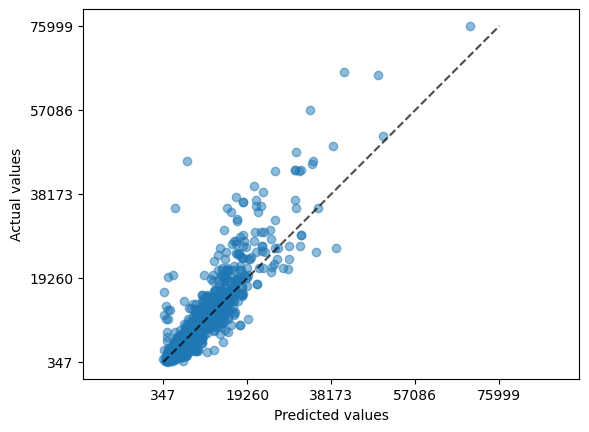

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_te.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

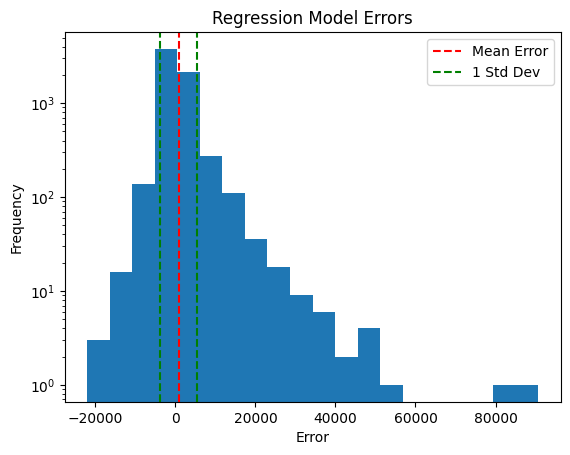

In [ ]:
plot_regression_errors(y_val, pipe_te.predict(X_val))

## Веса модели

1.  "Вытащим" из модели веса линейной регрессии

In [ ]:
b0 = pipe_te['model'].regressor_.intercept_
B = pipe_te['model'].regressor_.coef_
Bs = np.hstack([b0,B])

2. Подготовим список имен признаков (не забываем про независимую константу)

In [ ]:
columns = np.append('b0',num_scale)
columns = np.append(columns,num_power)
columns = np.append(columns,cat_columns) # объединяем названия колонок

3. Рисуем с помощью функцию, которую нам сделала ChatGPT

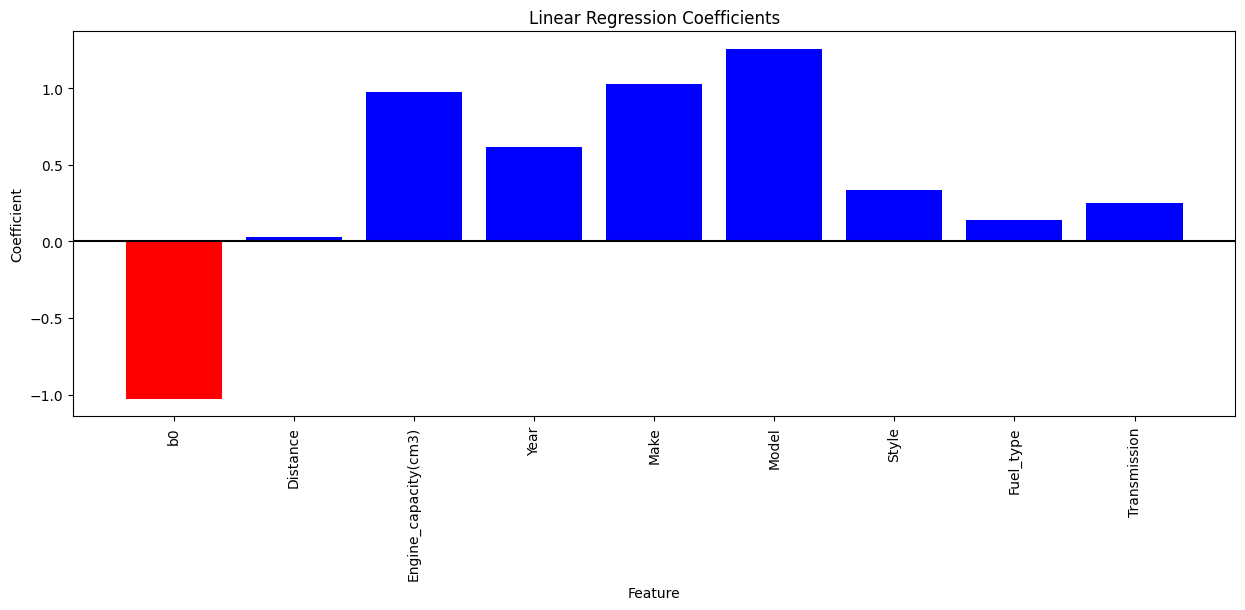

In [ ]:
fig = plt.figure(figsize = (15,5))
analyze_regression(Bs,columns, 0.01)

Вроде как "моделька попроще"

Но надо заходить "внутрь" каждого признака